In [75]:
# === ENVIRONMENT SETUP ===
import sys
from pathlib import Path
import shutil

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Remove old repo if exists
    if Path('Projects').exists():
        shutil.rmtree('Projects')

    # Clone fresh copy
    !git clone https://github.com/Q-types/Projects.git
    sys.path.insert(0, '/content/Projects')
else:
    # Running locally - add project root to path
    project_root = Path.cwd()
    while project_root != project_root.parent:
        if (project_root / 'setup.py').exists():
            break
        project_root = project_root.parent
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    print(f"📁 Project root: {project_root}")

# Import my utilities
from data_science.data_utils import ensure_dataset
from data_science.colab_setup import CFG, apply_style

print(f"✅ Setup complete! Data folder: {CFG.data_folder}")


📁 Project root: /Users/q/Projects
✅ Setup complete! Data folder: /Users/q/Projects/data_science/datasets/raw


In [76]:
# === INSTALL PROPHET (Colab only) ===
if IN_COLAB:
    print("📦 Installing Prophet...")
    !pip install -q prophet
    print("✅ Prophet installed!")

In [77]:
import itertools
from tokenize import PlainToken
import pandas as pd
import numpy as np
from random import gauss
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Apply my custom plotting style (imported from cell 1)
apply_style('clean')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go

print("✅ Imports complete")



✅ Imports complete


✅ Dataset 'us_covid' already available


<Axes: >

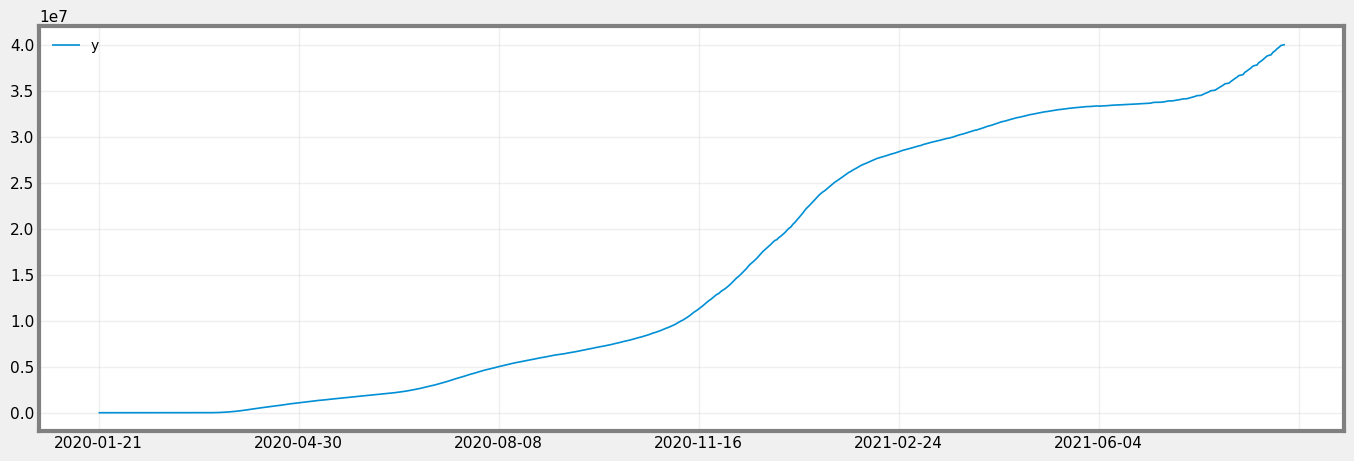

In [78]:
# Ensure dataset is available (downloads if needed)
data_folder = ensure_dataset("us_covid")

# Load data
df = pd.read_csv(data_folder / "us_covid.csv")
xdat = df[["date","cases"]].rename(columns={"date":"ds","cases":"y"})
xdat.set_index("ds").plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel="")

17:16:12 - cmdstanpy - INFO - Chain [1] start processing
17:16:12 - cmdstanpy - INFO - Chain [1] done processing


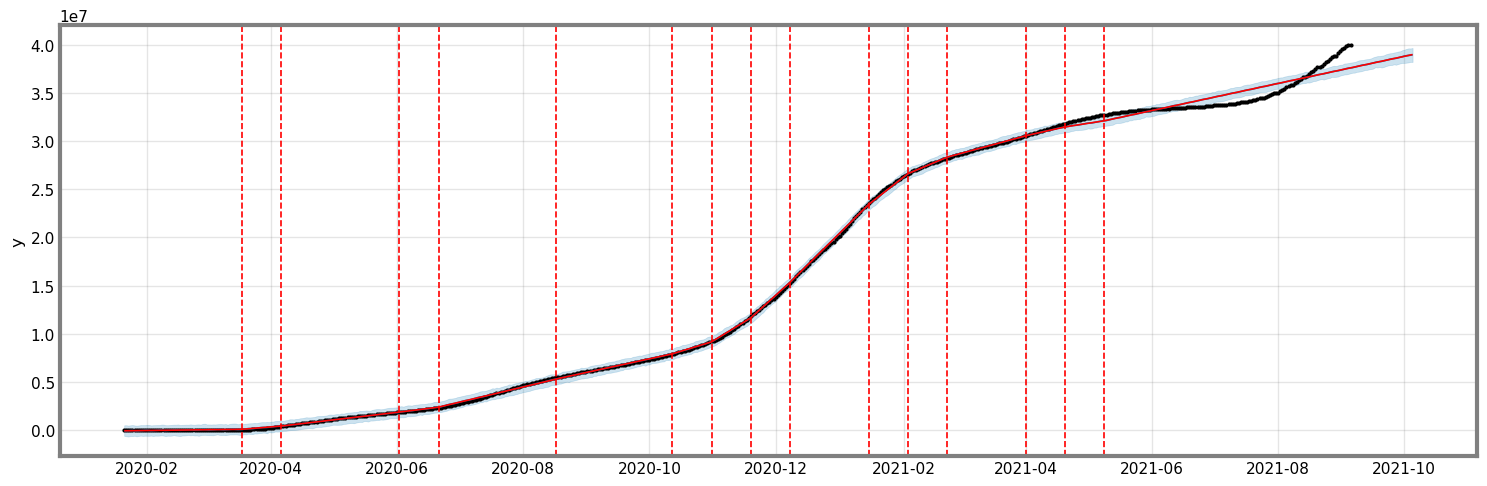

In [79]:
# automatic detection of change points

m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods=30)
forcast = m.predict(future)
fig = m.plot(forcast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [80]:
# Re-install Prophet with necessary dependencies
if IN_COLAB:
    print("📦 Re-installing Prophet with dependencies...")
    !pip install -q --upgrade --no-cache-dir prophet cmdstanpy
    print("✅ Prophet re-installed!")

17:16:12 - cmdstanpy - INFO - Chain [1] start processing
17:16:12 - cmdstanpy - INFO - Chain [1] done processing


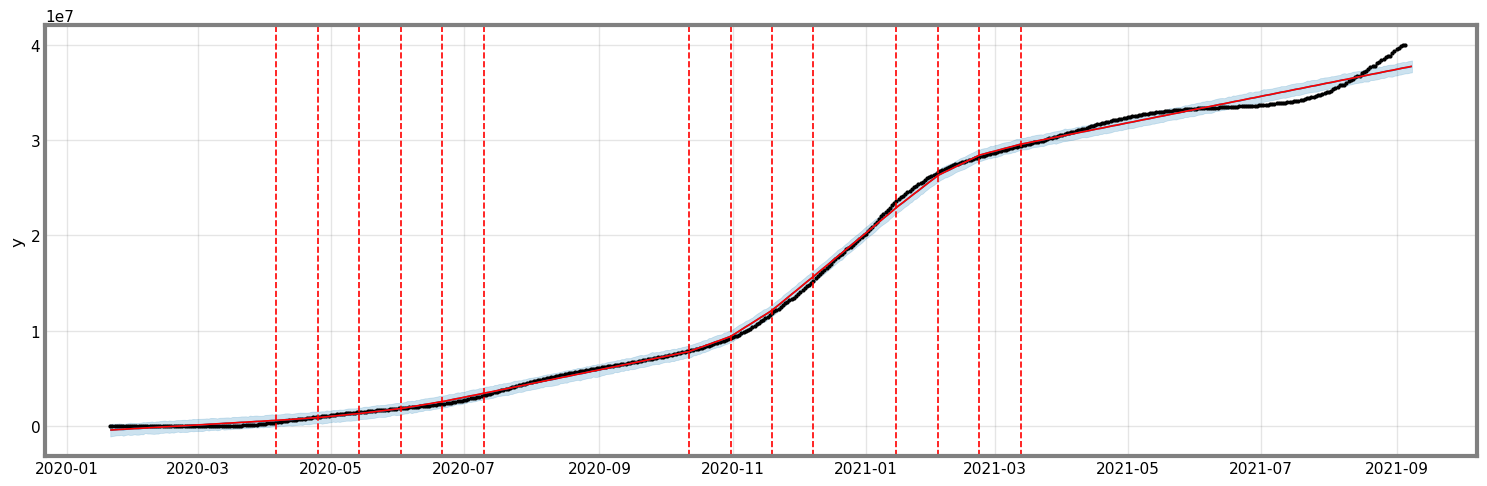

In [81]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods=3)
forcast = m.predict(future)
fig = m.plot(forcast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [82]:
# Ensure WHO dataset is available
ensure_dataset("who_cases")

# Load using CFG.data_folder
df = pd.read_csv(CFG.data_folder / "WHO_full_data2003.csv")

✅ Dataset 'who_cases' already available


<Axes: >

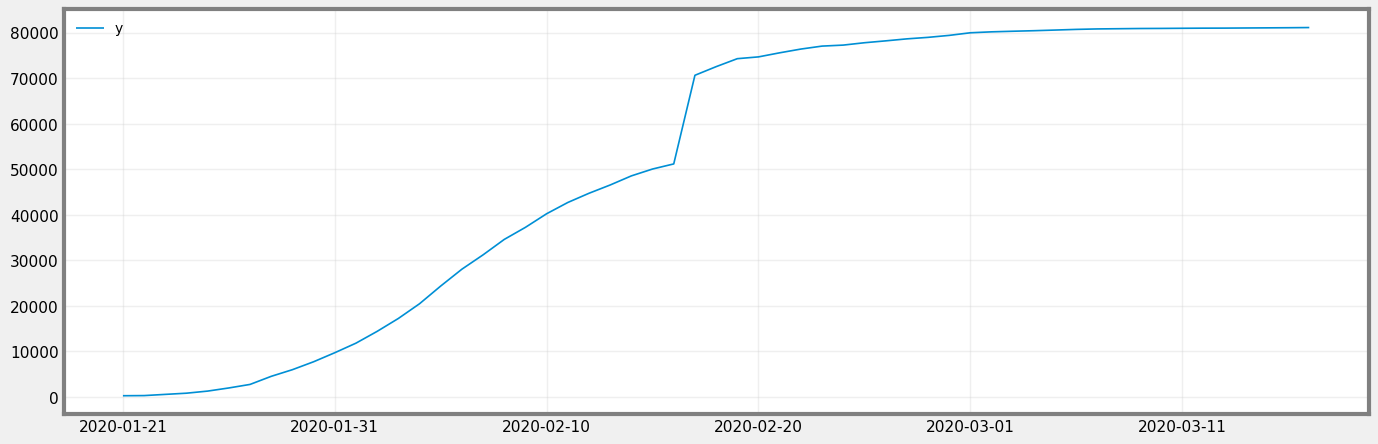

In [83]:
# Subset data and rename to Prophet naming convention

df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={'date':'ds', 'total_cases':'y'})
df.set_index('ds').plot(figsize=(CFG.img_dim1,CFG.img_dim2), xlabel='')

The curve of cases begins to flatten. Usign prophet we can incorporate such knowledge into the model by setting an upper bound

17:16:13 - cmdstanpy - INFO - Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing


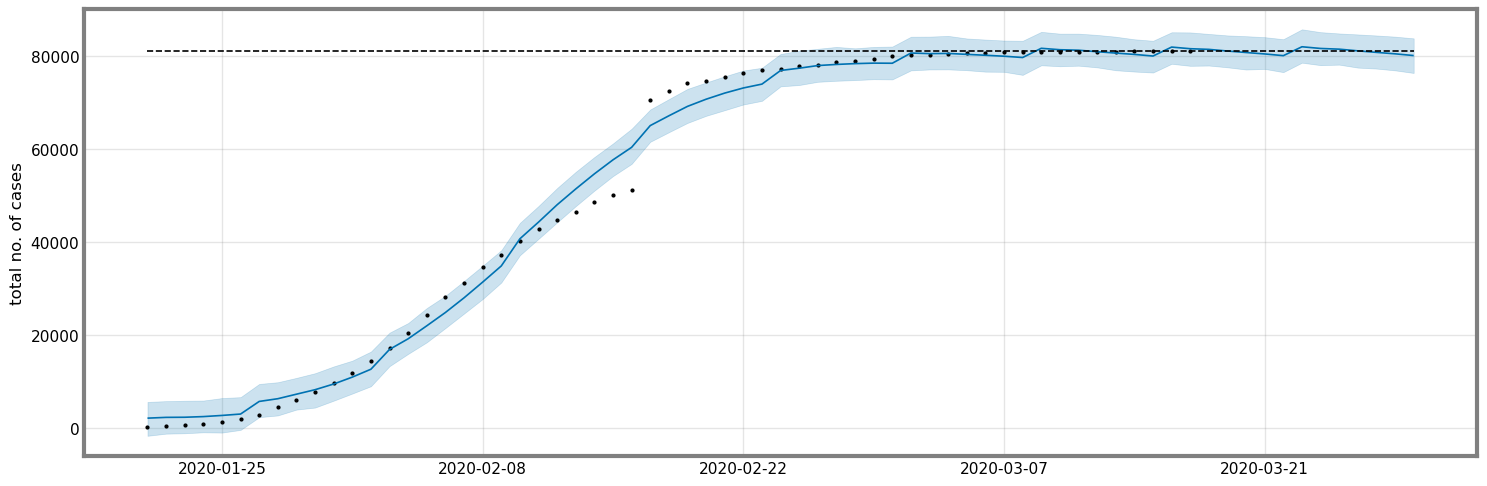

In [84]:
# adding cap

df['cap'] = df['y'].max()

# fit model
m = Prophet(growth='logistic')
m.fit(df)

# prediction
future = m.make_future_dataframe(periods=12)
future['cap'] = df['cap'].iloc[-1]

# plot results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total no. of cases')

17:16:13 - cmdstanpy - INFO - Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing


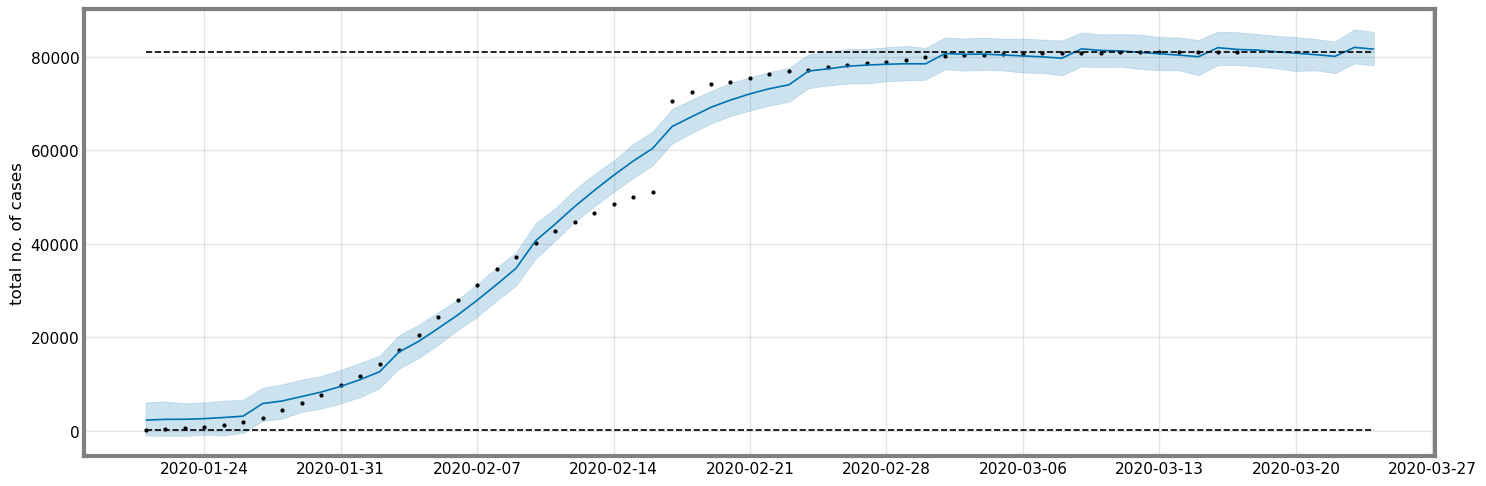

In [85]:
# now settign lower bounds

df['cap'] = df['y'].max()
df['floor'] = df['y'].min()

# fit model
m= Prophet(growth='logistic')
m.fit(df)

# prediction
future = m.make_future_dataframe(periods=7)
future['cap'] = df['cap'].iloc[-1]
future['floor'] = df['floor'].iloc[-1]
fcst = m.predict(future)

fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total no. of cases')

Seasonality

When dealing with dat in practical aplications, it is frewuently necessary to take into account multiple seasonal patterns occourring in parallel.

$$
S(t) = \sum_{i=1}^{N} \left( a_i \cos\left( \frac{2\pi i t}{P} \right) + b_i \sin\left( \frac{2\pi i t}{P} \right) \right)
$$

Now exploring how to specify different seasonalit patterns using energy consuption data form the PJM Interconnection LLC (PJM)

In [86]:
ensure_dataset("pjm_hourly")
df = pd.read_csv(CFG.data_folder / "pjm_hourly_est.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

✅ Dataset 'pjm_hourly' already available


,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


<Axes: xlabel='ds'>

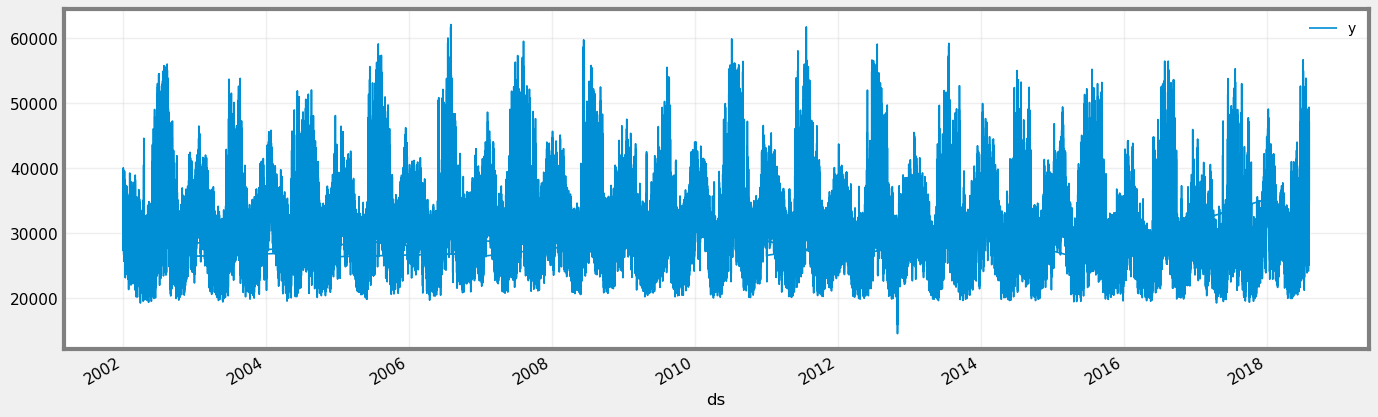

In [87]:
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={'Datetime':'ds', 'PJME':'y'})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

17:16:14 - cmdstanpy - INFO - Chain [1] start processing
17:16:14 - cmdstanpy - INFO - Chain [1] done processing


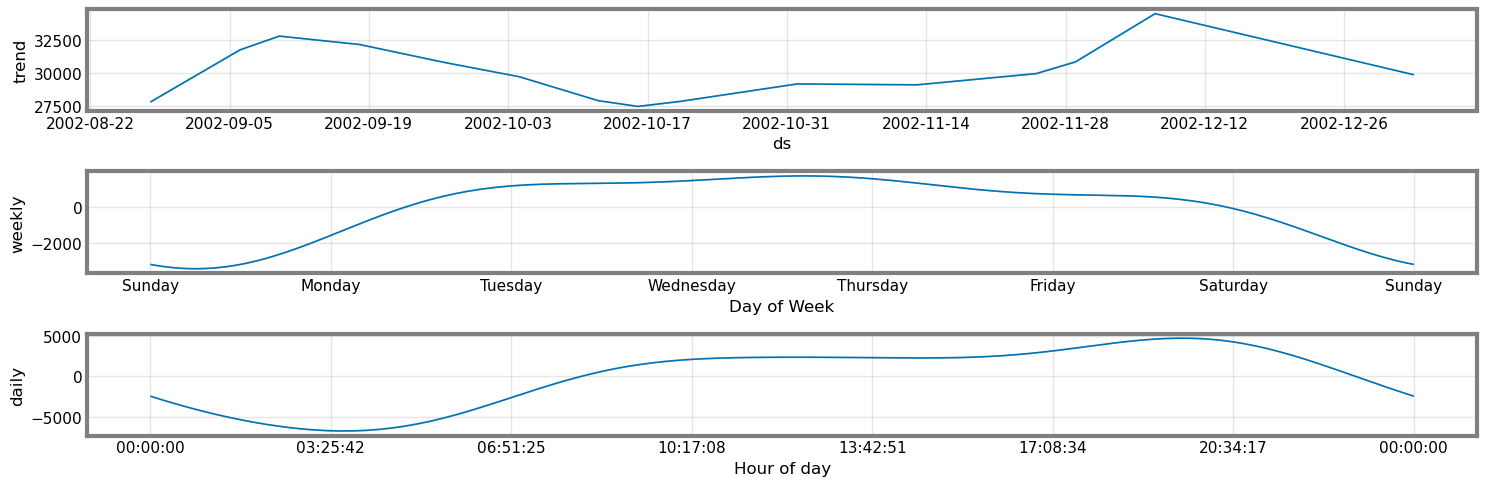

In [88]:
# we only need to keep at least two cycles, so reduce dataset with iloc

m = Prophet().fit(xdat.iloc[:3000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forcast = m.predict(future)
fig = m.plot_components(forcast, figsize=(CFG.img_dim1, CFG.img_dim2))


<Axes: >

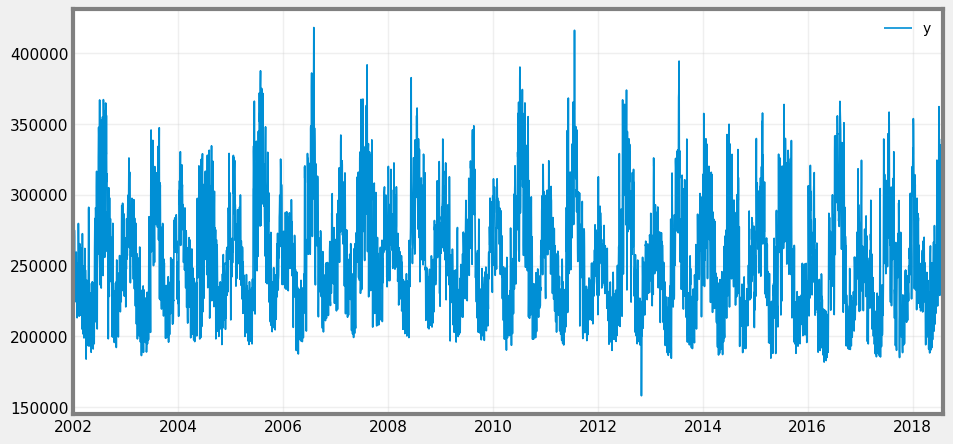

In [89]:
# agrigating the data to daily
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={'Datetime':'ds', 'PJME':'y'})
xdat['y'] /= 10^9

# purge the leading zeroes and last observation (which was partial)
ix = np.where(xdat['y'] > 0)[0][0]
xdat =xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')

17:16:15 - cmdstanpy - INFO - Chain [1] start processing
17:16:15 - cmdstanpy - INFO - Chain [1] done processing


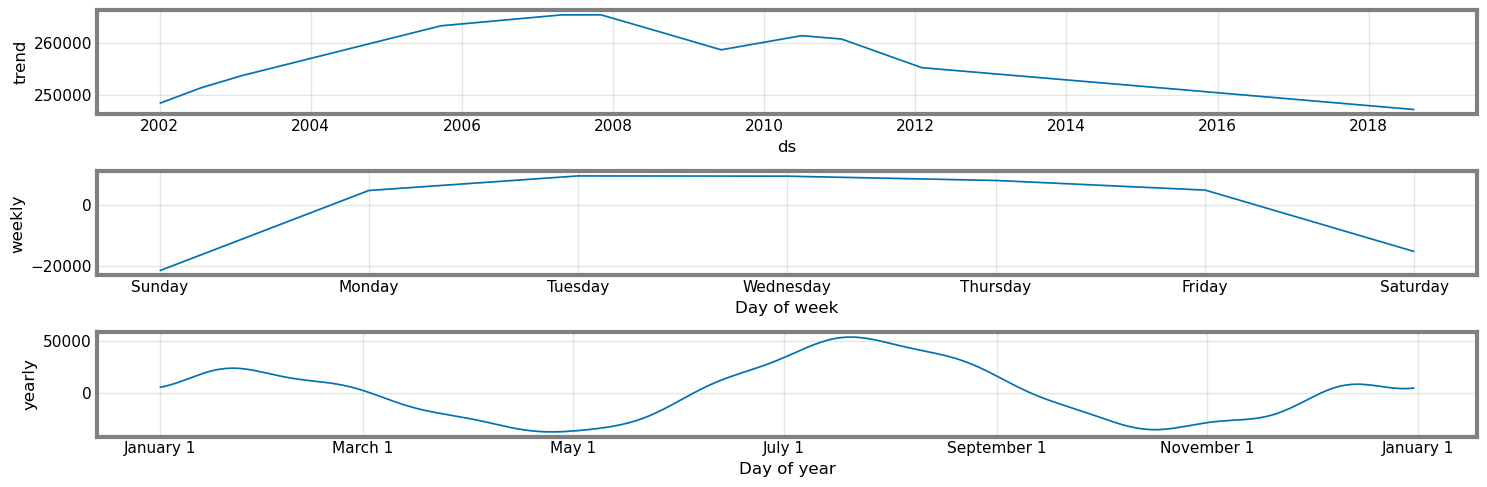

In [90]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forcast = m.predict(future)
fig = m.plot_components(forcast, figsize=(CFG.img_dim1, CFG.img_dim2))


<Axes: >

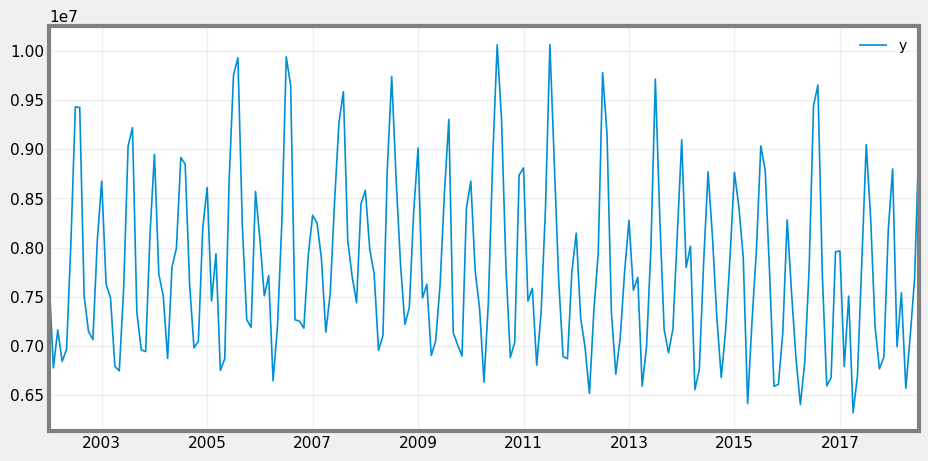

In [91]:
# downsampling further
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9

ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')

17:16:16 - cmdstanpy - INFO - Chain [1] start processing
17:16:16 - cmdstanpy - INFO - Chain [1] done processing


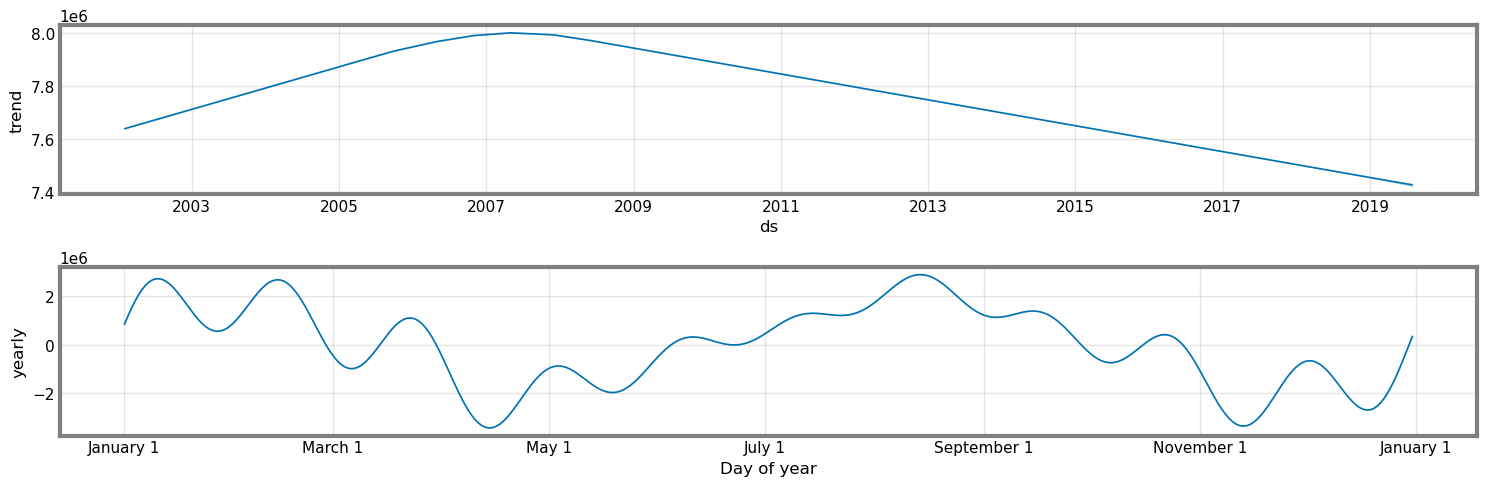

In [92]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forcast = m.predict(future)
fig = m.plot_components(forcast, figsize=(CFG.img_dim1, CFG.img_dim2))

